# Dependency specification:

Code to use and update requirement.txt
pip install -r requirements.txt
Update requirements.txt (add xgboost)


### Code for shah-dev branch
git checkout shah-dev
git add .
git commit -m "Work on strategy testing"
git push origin shah-dev



### This parameter tunes across assets

In [2]:
# # DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))  # adds project root

## Imports

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
from src.functions.position_VB import positionVB
import plotly.express as px
from src.functions.plot_position import plot_positions_2mas
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Groups of assets

The groups of assets include:

- **Group 1** – two assets (1-minute frequency), **traded during NYSE sessions** on working days between **9:30 and 16:00 CET**:
  - **SP** – futures contract for S&P 500 index (transaction cost = 12$, point value = 50$).
  - **NQ** – futures contract for NASDAQ index (transaction cost = 12$, point value = 20$).


## Data

In [22]:
file_path = "../data/data2_2023_Q3.parquet"

dataQ3 = pd.read_parquet(file_path, engine="fastparquet")
dataQ3

,datetime,AUD,CAD,XAG,XAU
0,2023-07-02 18:05:00,0.66625,0.755207,22.745,1919.538
1,2023-07-02 18:10:00,0.66629,0.755196,22.745,1919.538
2,2023-07-02 18:15:00,0.66626,0.755110,22.745,1919.538
3,2023-07-02 18:20:00,0.66622,0.755059,22.745,1919.538
4,2023-07-02 18:25:00,0.66623,0.755116,22.745,1919.538
...,...,...,...,...,...
18534,2023-09-29 16:40:00,0.64328,0.736789,22.184,1849.618
18535,2023-09-29 16:45:00,0.64315,0.736800,22.174,1848.488
18536,2023-09-29 16:50:00,0.64341,0.736931,22.179,1848.945
18537,2023-09-29 16:55:00,0.64336,0.737028,22.184,1848.918


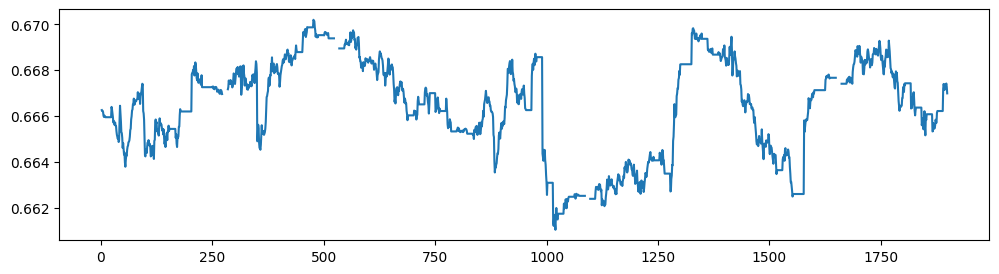

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,3))
plt.plot(dataQ3.iloc[2:1900,]["AUD"])

In [24]:
# APPLY MASK
def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Creates masks required by the assignment for Group 1:
    - NaN windows for calculations: 9:31-9:40 and 15:51-16:00
    - no trading: 9:31-9:55
    - flat from: 15:40 to end (no overnight)
    """
    t = index.time

    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close

    no_trade = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    flat_from = (t >= pd.to_datetime("15:40").time())

    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": no_trade, "mask_flat_from": flat_from},
        index=index
    )



In [48]:
dataQ3.columns

Index(['AUD', 'CAD', 'XAG', 'XAU', 'mask_no_trade', 'mask_flat_from'], dtype='object')

In [25]:

dataQ3 = dataQ3.set_index("datetime")
dataQ3.index

# build masks once
masks = add_group1_masks(dataQ3.index)

# 1) Enforce NaN windows at the DATA level (affects SMA/STD/trend automatically)
dataQ3.loc[masks["mask_nan"], "CAD"] = np.nan

# 2) Add control columns the strategy can read (no logic changes)
dataQ3["mask_no_trade"]  = masks["mask_no_trade"].astype(bool)
dataQ3["mask_flat_from"] = masks["mask_flat_from"].astype(bool)


In [26]:
dataQ3_ = dataQ3.copy()

In [27]:
dataQ3_.index

DatetimeIndex(['2023-07-02 18:05:00', '2023-07-02 18:10:00',
               '2023-07-02 18:15:00', '2023-07-02 18:20:00',
               '2023-07-02 18:25:00', '2023-07-02 18:30:00',
               '2023-07-02 18:35:00', '2023-07-02 18:40:00',
               '2023-07-02 18:45:00', '2023-07-02 18:50:00',
               ...
               '2023-09-29 16:15:00', '2023-09-29 16:20:00',
               '2023-09-29 16:25:00', '2023-09-29 16:30:00',
               '2023-09-29 16:35:00', '2023-09-29 16:40:00',
               '2023-09-29 16:45:00', '2023-09-29 16:50:00',
               '2023-09-29 16:55:00', '2023-09-29 17:00:00'],
              dtype='datetime64[us]', name='datetime', length=18539, freq=None)

In [28]:
dataQ3_= dataQ3_.resample('H').last()

In [29]:
dataQ3_.columns

Index(['AUD', 'CAD', 'XAG', 'XAU', 'mask_no_trade', 'mask_flat_from'], dtype='object')

In [30]:
# run SAME strategy per asset column (same quarter df = dataQ3_)
import numpy as np, pandas as pd

def run_one_asset(df, price_col):
    CAD = df[price_col].to_numpy()
    n   = len(df)

    TC = 10.0
    POINT_VALUE = 100000.0

    MASK_NO_TRADE  = df["mask_no_trade"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = df["mask_flat_from"].to_numpy(dtype=bool)

    ENTRY_CUTOFF = pd.to_datetime("14:30").time()
    MASK_NO_ENTRY_AFTER = (df.index.time >= ENTRY_CUTOFF)

    dS = np.diff(CAD)

    SMA_grid = [100, 150, 180]
    slow_mult_grid = [2.0, 2.5, 3.0]
    slope_m_grid = [3, 4, 5]
    z_entry_grid = [1.6, 1.8, 2.0]
    z_stop_grid  = [2.5, 3.0, 3.5]
    z_sl_grid    = [1.5, 2.0, 2.5]
    z_mom_grid   = [0.3, 0.4, 0.5]
    cooldown_grid = [5]

    best_net_pnl = -np.inf
    best_params  = None

    for SMA_win in SMA_grid:
        SMA = pd.Series(CAD).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
        STD = pd.Series(CAD).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
        z   = (CAD - SMA) / np.where(STD == 0, np.nan, STD)

        for slow_mult in slow_mult_grid:
            SMA_slow_win = int(slow_mult * SMA_win)
            SMA_slow = pd.Series(CAD).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

            for slope_m in slope_m_grid:
                for z_entry in z_entry_grid:
                    for z_stop in z_stop_grid:
                        for z_sl in z_sl_grid:
                            for z_mom in z_mom_grid:
                                for cooldown_bars in cooldown_grid:

                                    pos = np.zeros(n, dtype=np.int8)
                                    cooldown = 0

                                    for t in range(1, n):
                                        if MASK_FLAT_FROM[t-1]:
                                            pos[t] = 0
                                            cooldown = 0
                                            continue

                                        if (not np.isfinite(CAD[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
                                            not np.isfinite(z[t-1])  or not np.isfinite(SMA_slow[t-1])):
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if STD[t-1] <= 0:
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if t >= 2 and CAD[t-1] == CAD[t-2]:
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
                                            slow_up  = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
                                            slow_dn  = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
                                            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
                                            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
                                        else:
                                            trend_up = False
                                            trend_dn = False

                                        up_confirm = (t >= 2) and (CAD[t-1] > CAD[t-2])
                                        dn_confirm = (t >= 2) and (CAD[t-1] < CAD[t-2])

                                        if t >= 3 and np.isfinite(z[t-2]):
                                            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
                                            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
                                        else:
                                            z_up_mom = False
                                            z_dn_mom = False

                                        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
                                            pos[t] = 0
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
                                            pos[t] = 0
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if pos[t-1] == 0:
                                            if cooldown > 0:
                                                pos[t] = 0
                                            else:
                                                if (trend_up and up_confirm and z_up_mom and (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                                                    pos[t] = 1
                                                elif (trend_dn and dn_confirm and z_dn_mom and (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                                                    pos[t] = -1
                                                else:
                                                    pos[t] = 0

                                        elif pos[t-1] == 1:
                                            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                                                pos[t] = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = 1

                                        else:
                                            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                                                pos[t] = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = -1

                                        cooldown = cooldown - 1 if cooldown > 0 else 0

                                    trades  = np.abs(np.diff(pos))
                                    r_net   = POINT_VALUE * (pos[:-1] * dS) - TC * trades
                                    net_pnl = np.nansum(r_net)

                                    if net_pnl > best_net_pnl:
                                        best_net_pnl = net_pnl
                                        best_params  = (SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown_bars)

    return best_net_pnl, best_params


asset_cols = ['AUD', 'CAD', 'XAG', 'XAU']  # replace with your actual columns present in dataQ3_
results = {c: run_one_asset(dataQ3_, c) for c in asset_cols}

for c, (pnl, params) in results.items():
    print(c, "best_net_pnl:", pnl, "best_params:", params)


AUD best_net_pnl: 1264.0000000000032 best_params: (100, 3.0, 3, 2.0, 2.5, 1.5, 0.3, 5)
CAD best_net_pnl: 250.22773055121584 best_params: (150, 2.5, 3, 2.0, 2.5, 1.5, 0.3, 5)
XAG best_net_pnl: 119000.0000000005 best_params: (100, 3.0, 3, 1.6, 2.5, 1.5, 0.4, 5)
XAU best_net_pnl: 5564019.999999932 best_params: (100, 2.5, 3, 1.6, 2.5, 1.5, 0.3, 5)


### 1

## Load OOS

### Q4 2023

In [17]:
file_path = "../data/data2_2023_Q4.parquet"

data = pd.read_parquet(file_path, engine="fastparquet")
data = data.set_index("datetime")
# dataQ4.index

In [ ]:
best_params_AUD = (100, 3.0, 3, 2.0, 2.5, 1.5, 0.3, 5)
best_params_CAD = (150, 2.5, 3, 2.0, 2.5, 1.5, 0.3, 5)
best_params_XAG = (100, 3.0, 3, 1.6, 2.5, 1.5, 0.4, 5)
best_params_XAU = (100, 2.5, 3, 1.6, 2.5, 1.5, 0.3, 5)


In [39]:
# List of asset columns to process
asset_columns = ["CAD", "AUD", "XAU", "XAG"]

# Apply the mask and add control columns for each asset
for asset in asset_columns:
    # Build masks for each asset's data
    masks = add_group1_masks(data.index)
    
    # Enforce NaN windows for the specific asset
    data.loc[masks["mask_nan"], asset] = np.nan
    
    # Add control columns specific to each asset
    data[f"mask_no_trade_{asset}"] = masks["mask_no_trade"].astype(bool)
    data[f"mask_flat_from_{asset}"] = masks["mask_flat_from"].astype(bool)


In [43]:
# =========================
# RE-RUN ONCE WITH BEST PARAMS (OOS) — ALL ASSETS (same strategy, looped)
# =========================
import numpy as np
import pandas as pd
# from tqdm import tqdm
FLIP = False
assets = ["CAD", "AUD", "XAG", "XAU"]              # set yours
best_params_by_asset = {                          # fill with your per-asset best_params
    "AUD": best_params_AUD,
    "CAD": best_params_CAD,
    "XAG": best_params_XAG,
    "XAU": best_params_XAU,
}


ENTRY_CUTOFF = pd.to_datetime("14:30").time()
MASK_NO_ENTRY_AFTER = (data.index.time >= ENTRY_CUTOFF)

n = len(data)

for asset in assets:

    MASK_NO_TRADE  = data[f"mask_no_trade_{asset}"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = data[f"mask_flat_from_{asset}"].to_numpy(dtype=bool)
    SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown_bars = best_params_by_asset[asset]

    P = data[asset].to_numpy()

    SMA = pd.Series(P).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(P).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
    z   = (P - SMA) / np.where(STD == 0, np.nan, STD)

    SMA_slow_win = int(slow_mult * SMA_win)
    SMA_slow = pd.Series(P).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

    # save for plots/diagnostics (asset-specific)
    data[f"{asset}_SMA"]      = SMA
    data[f"{asset}_STD"]      = STD
    data[f"{asset}_z"]        = z
    data[f"{asset}_SMA_slow"] = SMA_slow

    pos    = np.zeros(n, dtype=np.int8)
    regime = np.zeros(n, dtype=np.int8)
    cooldown = 0

    for t in range(1, n):  # swap to tqdm(...) if you want
        if MASK_FLAT_FROM[t-1]:
            pos[t] = 0
            cooldown = 0
            regime[t] = 0
            continue

        if (not np.isfinite(P[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
            not np.isfinite(z[t-1]) or not np.isfinite(SMA_slow[t-1])):
            pos[t] = pos[t-1]
            regime[t] = pos[t]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if STD[t-1] <= 0:
            pos[t] = pos[t-1]
            regime[t] = pos[t]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t >= 2 and P[t-1] == P[t-2]:
            pos[t] = pos[t-1]
            regime[t] = pos[t]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
            slow_up  = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
            slow_dn  = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
        else:
            trend_up = False
            trend_dn = False

        up_confirm = (t >= 2) and (P[t-1] > P[t-2])
        dn_confirm = (t >= 2) and (P[t-1] < P[t-2])

        if t >= 3 and np.isfinite(z[t-2]):
            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
        else:
            z_up_mom = False
            z_dn_mom = False

        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
            pos[t] = 0
            regime[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
            pos[t] = 0
            regime[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if pos[t-1] == 0:
            if cooldown > 0:
                pos[t] = 0
            else:
                if (trend_up and up_confirm and z_up_mom and (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                    pos[t] = 1
                elif (trend_dn and dn_confirm and z_dn_mom and (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                    pos[t] = -1
                else:
                    pos[t] = 0

        elif pos[t-1] == 1:
            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = 1
        else:
            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = -1

        cooldown = cooldown - 1 if cooldown > 0 else 0
        regime[t] = pos[t]

    data[f"position_3_{asset}"] = (-pos if FLIP else pos)
    data[f"regime_3_{asset}"]   = regime


### Diagnostics Q4 2023

In [ ]:
# Define the transaction cost and point value for each asset
asset_params = {
    "CAD": {"tc": 10, "pv": 100000},
    "AUD": {"tc": 10, "pv": 100000},
    "XAU": {"tc": 15, "pv": 100},
    "XAG": {"tc": 10, "pv": 5000}
}

# Iterate over assets
for asset in assets:
    # Fetch the transaction cost and point value for the asset
    tc = asset_params[asset]["tc"]
    pv = asset_params[asset]["pv"]

    # Calculate net profit for the asset (considering transaction costs)
    net_profit = np.nansum(data[f"position_3_{asset}"].to_numpy()[:-1] * np.diff(data[f"{asset}"].to_numpy()) * pv) - tc * np.abs(np.diff(data[f"position_3_{asset}"]).sum())

    # Calculate Sharpe ratio for the asset (considering transaction costs)
    sharpe = np.nanmean(data[f"position_3_{asset}"].to_numpy()[:-1] * np.diff(data[f"{asset}"].to_numpy()) * pv) / np.nanstd(data[f"position_3_{asset}"].to_numpy()[:-1] * np.diff(data[f"{asset}"].to_numpy()) * pv)

    print(f"Net Profit for  {asset}: {net_profit}, Sharpe Ratio for {asset}: {sharpe}")


Net Profit for CAD: -2108.2387117802414, Sharpe Ratio for CAD: -0.013643965049082597
Net Profit for AUD: -1315.000000000077, Sharpe Ratio for AUD: -0.0071930201620085165
Net Profit for XAG: 4320.00000000006, Sharpe Ratio for XAG: 0.0034847775712014855
Net Profit for XAU: 7116.900000000078, Sharpe Ratio for XAU: 0.007292563891465339


### Q4 2024

In [ ]:
# =========================
# RE-RUN ONCE WITH BEST PARAMS (OOS) — ALL ASSETS (same strategy, looped)
# =========================
import numpy as np
import pandas as pd
# from tqdm import tqdm
FLIP = False
assets = ["CAD", "AUD", "XAG", "XAU"]              # set yours
best_params_by_asset = {                          # fill with your per-asset best_params
    "AUD": best_params_AUD,
    "CAD": best_params_CAD,
    "XAG": best_params_XAG,
    "XAU": best_params_XAU,
}


ENTRY_CUTOFF = pd.to_datetime("14:30").time()
MASK_NO_ENTRY_AFTER = (data.index.time >= ENTRY_CUTOFF)

n = len(data)

for asset in assets:

    MASK_NO_TRADE  = data[f"mask_no_trade_{asset}"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = data[f"mask_flat_from_{asset}"].to_numpy(dtype=bool)
    SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown_bars = best_params_by_asset[asset]

    P = data[asset].to_numpy()

    SMA = pd.Series(P).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(P).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
    z   = (P - SMA) / np.where(STD == 0, np.nan, STD)

    SMA_slow_win = int(slow_mult * SMA_win)
    SMA_slow = pd.Series(P).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

    # save for plots/diagnostics (asset-specific)
    data[f"{asset}_SMA"]      = SMA
    data[f"{asset}_STD"]      = STD
    data[f"{asset}_z"]        = z
    data[f"{asset}_SMA_slow"] = SMA_slow

    pos    = np.zeros(n, dtype=np.int8)
    regime = np.zeros(n, dtype=np.int8)
    cooldown = 0

    for t in range(1, n):  # swap to tqdm(...) if you want
        if MASK_FLAT_FROM[t-1]:
            pos[t] = 0
            cooldown = 0
            regime[t] = 0
            continue

        if (not np.isfinite(P[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
            not np.isfinite(z[t-1]) or not np.isfinite(SMA_slow[t-1])):
            pos[t] = pos[t-1]
            regime[t] = pos[t]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if STD[t-1] <= 0:
            pos[t] = pos[t-1]
            regime[t] = pos[t]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t >= 2 and P[t-1] == P[t-2]:
            pos[t] = pos[t-1]
            regime[t] = pos[t]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
            slow_up  = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
            slow_dn  = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
        else:
            trend_up = False
            trend_dn = False

        up_confirm = (t >= 2) and (P[t-1] > P[t-2])
        dn_confirm = (t >= 2) and (P[t-1] < P[t-2])

        if t >= 3 and np.isfinite(z[t-2]):
            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
        else:
            z_up_mom = False
            z_dn_mom = False

        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
            pos[t] = 0
            regime[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
            pos[t] = 0
            regime[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if pos[t-1] == 0:
            if cooldown > 0:
                pos[t] = 0
            else:
                if (trend_up and up_confirm and z_up_mom and (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                    pos[t] = 1
                elif (trend_dn and dn_confirm and z_dn_mom and (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                    pos[t] = -1
                else:
                    pos[t] = 0

        elif pos[t-1] == 1:
            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = 1
        else:
            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = -1

        cooldown = cooldown - 1 if cooldown > 0 else 0
        regime[t] = pos[t]

    data[f"position_3_{asset}"] = (-pos if FLIP else pos)
    data[f"regime_3_{asset}"]   = regime


In [14]:

# Analyze trades
pos = data["position_3"].to_numpy()
px  = data["CAD"].to_numpy()

# use datetime index if present; else fallback to row number
ts = data.index.to_numpy() if getattr(data.index, "dtype", None) is not None else np.arange(len(data))

dpos = np.diff(pos)
trade_idx = np.where(dpos != 0)[0] + 1  # t where position changes

trades_df = pd.DataFrame({
    "t": trade_idx,
    "time": ts[trade_idx],
    "pos_prev": pos[trade_idx - 1],
    "pos_new":  pos[trade_idx],
    "trade_size": dpos[trade_idx - 1],          # +1 buy, -1 sell, +2/-2 flip
    "price": px[trade_idx],
    "dS_1": px[np.minimum(trade_idx + 1, len(px)-1)] - px[trade_idx],
    "dS_5": px[np.minimum(trade_idx + 5, len(px)-1)] - px[trade_idx],
})

print("num_trades =", len(trades_df))
print(trades_df.head(30).to_string(index=False))


num_trades = 40
    t                time  pos_prev  pos_new  trade_size    price      dS_1      dS_5
  772 2023-10-04 09:25:00         0       -1          -1 0.728173  0.000255 -0.000773
  848 2023-10-04 15:45:00        -1        0           1 0.727966 -0.000191 -0.000455
 1004 2023-10-05 04:45:00         0       -1          -1 0.726417 -0.000322 -0.000701
 1136 2023-10-05 15:45:00        -1        0           1 0.729421  0.000011  0.000037
 3684 2023-10-18 12:05:00         0       -1          -1 0.730487 -0.000187 -0.000986
 3728 2023-10-18 15:45:00        -1        0           1 0.729384 -0.000149  0.000053
 4483 2023-10-23 06:40:00         0       -1          -1 0.728019  0.000196  0.000186
 4529 2023-10-23 10:30:00        -1        0           1 0.730002 -0.000149  0.000667
 4813 2023-10-24 10:10:00         0       -1          -1 0.728475 -0.000074 -0.000265
 4880 2023-10-24 15:45:00        -1        0           1 0.728231  0.000095  0.000042
 5101 2023-10-25 10:10:00         0   

## Param Tuning on all quarters

In [41]:
# =========================
# RUN YOUR FINAL TUNING BLOCK ON ALL ../data/*.parquet FOR BOTH SP + NQ + SUMMARY TABLE
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    t = index.time
    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close
    mask_no_trade  = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    mask_flat_from = (t >= pd.to_datetime("15:40").time())
    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": mask_no_trade, "mask_flat_from": mask_flat_from},
        index=index
    )

def tune_one_asset(df: pd.DataFrame, asset: str, point_value: float, tc: float) -> dict:
    # expects df indexed by datetime with df[asset], mask_no_trade, mask_flat_from
    FLIP = False  # kept for parity; unused in tuning

    Px = df[asset].to_numpy()
    n  = len(df)

    MASK_NO_TRADE  = df["mask_no_trade"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = df["mask_flat_from"].to_numpy(dtype=bool)

    ENTRY_CUTOFF = pd.to_datetime("14:30").time()
    MASK_NO_ENTRY_AFTER = (df.index.time >= ENTRY_CUTOFF)

    dS = np.diff(Px)

    # ----- your grids (unchanged) -----
    SMA_grid        = [240, 360, 480]
    slow_mult_grid  = [3, 4]
    slope_m_grid    = [5, 10]
    z_entry_grid    = [1.4, 1.6, 1.8, 2.0]
    z_stop_grid     = [3.5, 4.0, 4.5]
    z_sl_grid       = [1.0, 1.5, 2.0]
    z_mom_grid      = [0.05, 0.10, 0.20, 0.30]
    cooldown_grid   = [5, 10]
    # -------------------------------

    best_net_pnl = -np.inf
    best_params  = None
    best_trades  = np.nan

    for SMA_win in SMA_grid:

        SMA = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
        STD = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
        z   = (Px - SMA) / np.where(STD == 0, np.nan, STD)

        for slow_mult in slow_mult_grid:

            SMA_slow_win = int(slow_mult * SMA_win)
            SMA_slow = pd.Series(Px).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

            for slope_m in slope_m_grid:
                for z_entry in z_entry_grid:
                    for z_stop in z_stop_grid:
                        for z_sl in z_sl_grid:
                            for z_mom in z_mom_grid:
                                for cooldown_bars in cooldown_grid:

                                    pos = np.zeros(n, dtype=np.int8)
                                    cooldown = 0

                                    for t in range(1, n):

                                        if MASK_FLAT_FROM[t-1]:
                                            pos[t] = 0
                                            cooldown = 0
                                            continue

                                        if (not np.isfinite(Px[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
                                            not np.isfinite(z[t-1])  or not np.isfinite(SMA_slow[t-1])):
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if STD[t-1] <= 0:
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if t >= 2 and Px[t-1] == Px[t-2]:
                                            pos[t] = pos[t-1]
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        # ----- Change A: level + slope trend -----
                                        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
                                            slow_up = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
                                            slow_dn = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
                                            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
                                            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
                                        else:
                                            trend_up = False
                                            trend_dn = False
                                        # ----------------------------------------

                                        up_confirm = (t >= 2) and (Px[t-1] > Px[t-2])
                                        dn_confirm = (t >= 2) and (Px[t-1] < Px[t-2])

                                        if t >= 3 and np.isfinite(z[t-2]):
                                            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
                                            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
                                        else:
                                            z_up_mom = False
                                            z_dn_mom = False

                                        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
                                            pos[t] = 0
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
                                            pos[t] = 0
                                            cooldown = cooldown - 1 if cooldown > 0 else 0
                                            continue

                                        if pos[t-1] == 0:

                                            if cooldown > 0:
                                                pos[t] = 0
                                            else:
                                                if (trend_up and up_confirm and z_up_mom and
                                                    (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                                                    pos[t] = 1
                                                elif (trend_dn and dn_confirm and z_dn_mom and
                                                      (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                                                    pos[t] = -1
                                                else:
                                                    pos[t] = 0

                                        elif pos[t-1] == 1:
                                            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                                                pos[t] = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = 1

                                        else:  # pos[t-1] == -1
                                            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                                                pos[t] = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = -1

                                        cooldown = cooldown - 1 if cooldown > 0 else 0

                                    trades  = np.abs(np.diff(pos))
                                    r_net   = point_value * (pos[:-1] * dS) - tc * trades
                                    net_pnl = np.nansum(r_net)

                                    if net_pnl > best_net_pnl:
                                        best_net_pnl = net_pnl
                                        best_params  = (SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown_bars)
                                        best_trades  = int(np.nansum(trades))

    return {
        "net_pnl": float(best_net_pnl),
        "trades": best_trades,
        "SMA_win": best_params[0],
        "slow_mult": best_params[1],
        "slope_m": best_params[2],
        "z_entry": best_params[3],
        "z_stop": best_params[4],
        "z_sl": best_params[5],
        "z_mom": best_params[6],
        "cooldown": best_params[7],
    }

DATA_DIR = Path("../data")
rows = []

TX_COST = {"SP": 12.0, "NQ": 12.0}
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}

for fp in sorted(DATA_DIR.glob("*.parquet")):
    dfq = pd.read_parquet(fp)

    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)

    dfq = dfq.sort_index()
    quarter = fp.stem

    masks = add_group1_masks(dfq.index)
    dfq["mask_no_trade"]  = masks["mask_no_trade"].to_numpy(dtype=bool)
    dfq["mask_flat_from"] = masks["mask_flat_from"].to_numpy(dtype=bool)

    for asset in ["SP", "NQ"]:
        out = tune_one_asset(dfq, asset, point_value=POINT_VALUE[asset], tc=TX_COST[asset])
        rows.append({"quarter": quarter, "asset": asset, **out})

summary = pd.DataFrame(rows).sort_values(["quarter", "asset"]).reset_index(drop=True)
summary


,quarter,asset,net_pnl,trades,SMA_win,slow_mult,slope_m,z_entry,z_stop,z_sl,z_mom,cooldown
0,data1_2023_Q1,NQ,18383.12,80,480,4,10,1.4,4.5,2.0,0.05,5
1,data1_2023_Q1,SP,1181.75,100,240,3,5,1.4,4.0,1.0,0.10,5
2,data1_2023_Q3,NQ,10071.20,34,480,3,5,1.8,4.5,1.0,0.30,5
3,data1_2023_Q3,SP,5146.35,50,480,4,5,1.4,4.0,2.0,0.30,5
4,data1_2023_Q4,NQ,28336.64,80,360,3,10,1.6,3.5,2.0,0.10,5
5,data1_2023_Q4,SP,13969.40,92,360,3,5,1.4,3.5,2.0,0.05,5
6,data1_2024_Q2,NQ,33557.52,88,240,4,5,1.8,4.0,1.5,0.10,5
7,data1_2024_Q2,SP,4788.50,60,480,3,5,1.6,3.5,1.0,0.20,5
8,data1_2024_Q4,NQ,17438.26,112,240,3,10,1.4,3.5,1.0,0.05,5
9,data1_2024_Q4,SP,15212.95,80,360,4,5,1.6,3.5,1.0,0.05,5


In [42]:
from pathlib import Path

OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

# save the already-computed summary exactly as it is
summary.to_csv(OUTPUT_DIR / "strategy02_summary.csv", index=False)
summary.to_parquet(OUTPUT_DIR / "strategy02_summary.parquet", index=False)

print("Saved:", OUTPUT_DIR / "strategy02_summary.csv")


Saved: outputs_strategy02/strategy02_summary.csv


In [43]:
# =========================
# FAST PERF BUILD: NO TUNING. RE-RUN ONCE USING SAVED best params IN `summary`.
# Produces: outputs_strategy02/strategy02_perf.csv + per-quarter daily CSVs
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR   = Path("../data")
OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

TX_COST     = {"SP": 12.0, "NQ": 12.0}
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}

def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    t = index.time
    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close
    mask_no_trade  = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    mask_flat_from = (t >= pd.to_datetime("15:40").time())
    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": mask_no_trade, "mask_flat_from": mask_flat_from},
        index=index
    )

def _sharpe_annual(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2: return np.nan
    sd = x.std(ddof=1)
    if sd == 0 or not np.isfinite(sd): return np.nan
    return float(x.mean() / sd * np.sqrt(252))

def _calmar_annual(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2: return np.nan
    cum = x.cumsum()
    dd  = (cum - cum.cummax()).min()
    if not np.isfinite(dd) or dd == 0: return np.nan
    ann = x.mean() * 252
    return float(ann / abs(dd))

def summarize_daily(daily: pd.DataFrame) -> dict:
    return {
        "grossSR": _sharpe_annual(daily["gross_pnl"]),
        "netSR":   _sharpe_annual(daily["net_pnl"]),
        "grossCR": _calmar_annual(daily["gross_pnl"]),
        "netCR":   _calmar_annual(daily["net_pnl"]),
        "gross_cumPnL": float(daily["gross_pnl"].sum()),
        "net_cumPnL":   float(daily["net_pnl"].sum()),
        "av.ntrades":   float(daily["trades"].mean()) if len(daily) else np.nan,
    }

def run_params_pos(df: pd.DataFrame, asset: str, params: dict) -> np.ndarray:
    Px = df[asset].to_numpy()
    n  = len(df)

    MASK_NO_TRADE  = df["mask_no_trade"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = df["mask_flat_from"].to_numpy(dtype=bool)

    ENTRY_CUTOFF = pd.to_datetime("14:30").time()
    MASK_NO_ENTRY_AFTER = (df.index.time >= ENTRY_CUTOFF)

    SMA_win       = int(params["SMA_win"])
    slow_mult     = int(params["slow_mult"])
    slope_m       = int(params["slope_m"])
    z_entry       = float(params["z_entry"])
    z_stop        = float(params["z_stop"])
    z_sl          = float(params["z_sl"])
    z_mom         = float(params["z_mom"])
    cooldown_bars = int(params["cooldown"])

    SMA = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
    z   = (Px - SMA) / np.where(STD == 0, np.nan, STD)

    SMA_slow_win = int(slow_mult * SMA_win)
    SMA_slow = pd.Series(Px).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

    pos = np.zeros(n, dtype=np.int8)
    cooldown = 0

    for t in range(1, n):

        if MASK_FLAT_FROM[t-1]:
            pos[t] = 0
            cooldown = 0
            continue

        if (not np.isfinite(Px[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
            not np.isfinite(z[t-1])  or not np.isfinite(SMA_slow[t-1])):
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if STD[t-1] <= 0:
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t >= 2 and Px[t-1] == Px[t-2]:
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        # trend: level + slope
        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
            slow_up = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
            slow_dn = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
        else:
            trend_up = False
            trend_dn = False

        up_confirm = (t >= 2) and (Px[t-1] > Px[t-2])
        dn_confirm = (t >= 2) and (Px[t-1] < Px[t-2])

        if t >= 3 and np.isfinite(z[t-2]):
            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
        else:
            z_up_mom = False
            z_dn_mom = False

        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
            pos[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
            pos[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if pos[t-1] == 0:
            if cooldown > 0:
                pos[t] = 0
            else:
                if (trend_up and up_confirm and z_up_mom and (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                    pos[t] = 1
                elif (trend_dn and dn_confirm and z_dn_mom and (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                    pos[t] = -1
                else:
                    pos[t] = 0

        elif pos[t-1] == 1:
            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = 1

        else:  # -1
            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = -1

        cooldown = cooldown - 1 if cooldown > 0 else 0

    return pos

def daily_from_intraday(index: pd.DatetimeIndex, gross_intr: np.ndarray, net_intr: np.ndarray, trades_intr: np.ndarray) -> pd.DataFrame:
    dates = pd.to_datetime(index[1:]).normalize()
    daily = pd.DataFrame({"date": dates, "gross_pnl": gross_intr, "net_pnl": net_intr, "trades": trades_intr})
    daily = daily.groupby("date", as_index=False).sum()
    daily["date"] = pd.to_datetime(daily["date"])
    return daily.set_index("date").sort_index()

# ---- REQUIREMENT INPUT: `summary` must already exist (computed earlier) ----
# It must have: quarter, asset, SMA_win, slow_mult, slope_m, z_entry, z_stop, z_sl, z_mom, cooldown
need_cols = {"quarter","asset","SMA_win","slow_mult","slope_m","z_entry","z_stop","z_sl","z_mom","cooldown"}
missing = need_cols - set(summary.columns)
if missing:
    raise ValueError(f"`summary` is missing columns: {sorted(missing)}")

perf_rows = []

for fp in sorted(DATA_DIR.glob("*.parquet")):
    quarter = fp.stem
    dfq = pd.read_parquet(fp)

    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)

    dfq = dfq.sort_index()
    masks = add_group1_masks(dfq.index)
    dfq["mask_no_trade"]  = masks["mask_no_trade"].to_numpy(dtype=bool)
    dfq["mask_flat_from"] = masks["mask_flat_from"].to_numpy(dtype=bool)

    daily_by_asset = {}

    for asset in ["SP","NQ"]:
        p = summary[(summary["quarter"]==quarter) & (summary["asset"]==asset)].iloc[0].to_dict()

        pos = run_params_pos(dfq, asset, p)
        Px  = dfq[asset].to_numpy()
        dS  = np.diff(Px)
        trades_intr = np.abs(np.diff(pos)).astype(float)

        gross_intr = POINT_VALUE[asset] * (pos[:-1] * dS)
        net_intr   = gross_intr - TX_COST[asset] * trades_intr

        daily = daily_from_intraday(dfq.index, gross_intr, net_intr, trades_intr)
        daily_by_asset[asset] = daily

        daily.reset_index(names="date").to_csv(OUTPUT_DIR / f"{quarter}_{asset}_daily.csv", index=False)

        met = summarize_daily(daily)
        perf_rows.append({"quarter": quarter, "asset": asset, **met})

    # portfolio
    d_sp = daily_by_asset["SP"]
    d_nq = daily_by_asset["NQ"]
    idx  = d_sp.index.union(d_nq.index)
    port = pd.DataFrame(index=idx).fillna(0.0)
    port["gross_pnl"] = d_sp["gross_pnl"].reindex(idx, fill_value=0.0) + d_nq["gross_pnl"].reindex(idx, fill_value=0.0)
    port["net_pnl"]   = d_sp["net_pnl"].reindex(idx, fill_value=0.0)   + d_nq["net_pnl"].reindex(idx, fill_value=0.0)
    port["trades"]    = d_sp["trades"].reindex(idx, fill_value=0.0)    + d_nq["trades"].reindex(idx, fill_value=0.0)

    port.reset_index(names="date").to_csv(OUTPUT_DIR / f"{quarter}_PORTFOLIO_daily.csv", index=False)

    metp = summarize_daily(port)
    perf_rows.append({"quarter": quarter, "asset": "PORTFOLIO", **metp})

perf_table = pd.DataFrame(perf_rows).sort_values(["quarter","asset"]).reset_index(drop=True)
perf_table.to_csv(OUTPUT_DIR / "strategy02_perf.csv", index=False)
perf_table


,quarter,asset,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades
0,data1_2023_Q1,NQ,2.686558,2.555474,9.070388,8.424582,19343.12,18383.12,1.230769
1,data1_2023_Q1,PORTFOLIO,2.485800,2.240686,7.175615,6.307418,21724.87,19564.87,2.769231
2,data1_2023_Q1,SP,0.606230,0.299976,1.131809,0.533328,2381.75,1181.75,1.538462
3,data1_2023_Q3,NQ,2.708714,2.611590,15.236668,14.258424,10479.20,10071.20,0.523077
4,data1_2023_Q3,PORTFOLIO,2.905158,2.733451,15.429856,13.666741,16225.55,15217.55,1.292308
5,data1_2023_Q3,SP,2.546347,2.289967,9.755504,8.469850,5746.35,5146.35,0.769231
6,data1_2023_Q4,NQ,5.598015,5.427855,31.607716,29.598769,29296.64,28336.64,1.250000
7,data1_2023_Q4,PORTFOLIO,5.446326,5.206257,37.368490,31.867623,44370.04,42306.04,2.687500
8,data1_2023_Q4,SP,4.508426,4.184419,25.820722,22.742294,15073.40,13969.40,1.437500
9,data1_2024_Q2,NQ,4.577226,4.442719,37.152052,35.314663,34613.52,33557.52,1.353846


In [44]:
from pathlib import Path

OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

# save the already-computed perf_table exactly as it is
perf_table.to_csv(OUTPUT_DIR / "strategy02_perf.csv", index=False)
perf_table.to_parquet(OUTPUT_DIR / "strategy02_perf.parquet", index=False)

print("Saved:", OUTPUT_DIR / "strategy02_perf.csv")


Saved: outputs_strategy02/strategy02_perf.csv


## OOS

In [72]:
# =========================
# OOS PERF ONLY: run data1_2025_Q2.parquet using best params from data1_2025_Q1.parquet
# Prints perf_table (SP, NQ, PORTFOLIO) for Q2 2025 only
# Params source: outputs_strategy02/strategy02_summary.csv
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR   = Path("../data")
OUTPUT_DIR = Path("outputs_strategy02")
OUTPUT_DIR.mkdir(exist_ok=True)

TRAIN_Q = "data1_2024_Q2"   # params from here
TEST_Q  = "data1_2025_Q2"   # run OOS on this

TX_COST     = {"SP": 12.0, "NQ": 12.0}
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}

# ---- load saved best params (already computed earlier) ----
summary_path = OUTPUT_DIR / "strategy02_summary.csv"
summary = pd.read_csv(summary_path)

need_cols = {"quarter","asset","SMA_win","slow_mult","slope_m","z_entry","z_stop","z_sl","z_mom","cooldown"}
missing = need_cols - set(summary.columns)
if missing:
    raise ValueError(f"`summary` missing columns: {sorted(missing)} in {summary_path}")

def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    t = index.time
    mask_no_trade  = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    mask_flat_from = (t >= pd.to_datetime("15:40").time())
    return pd.DataFrame({"mask_no_trade": mask_no_trade, "mask_flat_from": mask_flat_from}, index=index)

def _sharpe_annual(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2: return np.nan
    sd = x.std(ddof=1)
    if sd == 0 or not np.isfinite(sd): return np.nan
    return float(x.mean() / sd * np.sqrt(252))

def _calmar_annual(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2: return np.nan
    cum = x.cumsum()
    dd  = (cum - cum.cummax()).min()
    if not np.isfinite(dd) or dd == 0: return np.nan
    ann = x.mean() * 252
    return float(ann / abs(dd))

def summarize_daily(daily: pd.DataFrame) -> dict:
    return {
        "grossSR": _sharpe_annual(daily["gross_pnl"]),
        "netSR":   _sharpe_annual(daily["net_pnl"]),
        "grossCR": _calmar_annual(daily["gross_pnl"]),
        "netCR":   _calmar_annual(daily["net_pnl"]),
        "gross_cumPnL": float(daily["gross_pnl"].sum()),
        "net_cumPnL":   float(daily["net_pnl"].sum()),
        "av.ntrades":   float(daily["trades"].mean()) if len(daily) else np.nan,
    }

def run_params_pos(df: pd.DataFrame, asset: str, params: dict) -> np.ndarray:
    Px = df[asset].to_numpy()
    n  = len(df)

    MASK_NO_TRADE  = df["mask_no_trade"].to_numpy(dtype=bool)
    MASK_FLAT_FROM = df["mask_flat_from"].to_numpy(dtype=bool)

    ENTRY_CUTOFF = pd.to_datetime("14:30").time()
    MASK_NO_ENTRY_AFTER = (df.index.time >= ENTRY_CUTOFF)

    SMA_win       = int(params["SMA_win"])
    slow_mult     = int(params["slow_mult"])
    slope_m       = int(params["slope_m"])
    z_entry       = float(params["z_entry"])
    z_stop        = float(params["z_stop"])
    z_sl          = float(params["z_sl"])
    z_mom         = float(params["z_mom"])
    cooldown_bars = int(params["cooldown"])

    SMA = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(Px).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
    z   = (Px - SMA) / np.where(STD == 0, np.nan, STD)

    SMA_slow_win = int(slow_mult * SMA_win)
    SMA_slow = pd.Series(Px).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()

    pos = np.zeros(n, dtype=np.int8)
    cooldown = 0

    for t in range(1, n):

        if MASK_FLAT_FROM[t-1]:
            pos[t] = 0
            cooldown = 0
            continue

        if (not np.isfinite(Px[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
            not np.isfinite(z[t-1])  or not np.isfinite(SMA_slow[t-1])):
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if STD[t-1] <= 0:
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t >= 2 and Px[t-1] == Px[t-2]:
            pos[t] = pos[t-1]
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if t-1-slope_m >= 0 and np.isfinite(SMA_slow[t-1-slope_m]):
            slow_up = SMA_slow[t-1] > SMA_slow[t-1-slope_m]
            slow_dn = SMA_slow[t-1] < SMA_slow[t-1-slope_m]
            trend_up = (SMA[t-1] > SMA_slow[t-1]) and slow_up
            trend_dn = (SMA[t-1] < SMA_slow[t-1]) and slow_dn
        else:
            trend_up = False
            trend_dn = False

        up_confirm = (t >= 2) and (Px[t-1] > Px[t-2])
        dn_confirm = (t >= 2) and (Px[t-1] < Px[t-2])

        if t >= 3 and np.isfinite(z[t-2]):
            z_up_mom = (z[t-1] >= z[t-2] + z_mom)
            z_dn_mom = (z[t-1] <= z[t-2] - z_mom)
        else:
            z_up_mom = False
            z_dn_mom = False

        if MASK_NO_TRADE[t-1] and pos[t-1] == 0:
            pos[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if MASK_NO_ENTRY_AFTER[t-1] and pos[t-1] == 0:
            pos[t] = 0
            cooldown = cooldown - 1 if cooldown > 0 else 0
            continue

        if pos[t-1] == 0:
            if cooldown > 0:
                pos[t] = 0
            else:
                if (trend_up and up_confirm and z_up_mom and (z[t-1] >= z_entry) and (z[t-1] <= z_stop)):
                    pos[t] = 1
                elif (trend_dn and dn_confirm and z_dn_mom and (z[t-1] <= -z_entry) and (z[t-1] >= -z_stop)):
                    pos[t] = -1
                else:
                    pos[t] = 0

        elif pos[t-1] == 1:
            if (z[t-1] <= -z_sl) or (trend_dn and z[t-1] < 0.0) or (z[t-1] <= -z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = 1

        else:  # -1
            if (z[t-1] >= z_sl) or (trend_up and z[t-1] > 0.0) or (z[t-1] >= z_stop):
                pos[t] = 0
                cooldown = cooldown_bars
            else:
                pos[t] = -1

        cooldown = cooldown - 1 if cooldown > 0 else 0

    return pos

def daily_from_intraday(index: pd.DatetimeIndex, gross_intr: np.ndarray, net_intr: np.ndarray, trades_intr: np.ndarray) -> pd.DataFrame:
    dates = pd.to_datetime(index[1:]).normalize()
    daily = pd.DataFrame({"date": dates, "gross_pnl": gross_intr, "net_pnl": net_intr, "trades": trades_intr})
    daily = daily.groupby("date", as_index=False).sum()
    daily["date"] = pd.to_datetime(daily["date"])
    return daily.set_index("date").sort_index()

# ---- load ONLY the OOS quarter ----
fp = DATA_DIR / f"{TEST_Q}.parquet"
dfq = pd.read_parquet(fp)
if "datetime" in dfq.columns:
    dfq["datetime"] = pd.to_datetime(dfq["datetime"])
    dfq = dfq.set_index("datetime")
else:
    dfq.index = pd.to_datetime(dfq.index)
dfq = dfq.sort_index()

masks = add_group1_masks(dfq.index)
dfq["mask_no_trade"]  = masks["mask_no_trade"].to_numpy(dtype=bool)
dfq["mask_flat_from"] = masks["mask_flat_from"].to_numpy(dtype=bool)

perf_rows = []
daily_by_asset = {}

for asset in ["SP", "NQ"]:
    # params come ONLY from TRAIN_Q, applied to TEST_Q
    p = summary[(summary["quarter"] == TRAIN_Q) & (summary["asset"] == asset)].iloc[0].to_dict()

    pos = run_params_pos(dfq, asset, p)
    Px  = dfq[asset].to_numpy()
    dS  = np.diff(Px)
    trades_intr = np.abs(np.diff(pos)).astype(float)

    gross_intr = POINT_VALUE[asset] * (pos[:-1] * dS)
    net_intr   = gross_intr - TX_COST[asset] * trades_intr

    daily = daily_from_intraday(dfq.index, gross_intr, net_intr, trades_intr)
    daily_by_asset[asset] = daily

    met = summarize_daily(daily)
    perf_rows.append({"quarter": TEST_Q, "asset": asset, **met})

# portfolio row (SP+NQ)
d_sp = daily_by_asset["SP"]
d_nq = daily_by_asset["NQ"]
idx  = d_sp.index.union(d_nq.index)
port = pd.DataFrame(index=idx).fillna(0.0)
port["gross_pnl"] = d_sp["gross_pnl"].reindex(idx, fill_value=0.0) + d_nq["gross_pnl"].reindex(idx, fill_value=0.0)
port["net_pnl"]   = d_sp["net_pnl"].reindex(idx, fill_value=0.0)   + d_nq["net_pnl"].reindex(idx, fill_value=0.0)
port["trades"]    = d_sp["trades"].reindex(idx, fill_value=0.0)    + d_nq["trades"].reindex(idx, fill_value=0.0)

metp = summarize_daily(port)
perf_rows.append({"quarter": TEST_Q, "asset": "PORTFOLIO", **metp})

perf_table = pd.DataFrame(perf_rows).sort_values(["quarter", "asset"]).reset_index(drop=True)
perf_table


,quarter,asset,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades
0,data1_2025_Q2,NQ,0.885976,0.760980,1.968454,1.631409,8202.62,7050.62,1.476923
1,data1_2025_Q2,PORTFOLIO,0.115411,-0.051570,0.239836,-0.102290,1277.02,-570.98,2.369231
2,data1_2025_Q2,SP,-1.693124,-1.858575,-2.781117,-2.881530,-6925.60,-7621.60,0.892308


In [63]:
from pathlib import Path

outdir = Path("outputs_strategy02")
outdir.mkdir(parents=True, exist_ok=True)

perf_table.to_csv(outdir / "strategy02_perf_OOS.csv", index=False)
